In [1]:
import pandas as pd
import numpy as np

In [2]:
results_df = pd.read_csv('dataset/results.csv')
drivers_df = pd.read_csv('dataset/drivers.csv')
constructor_standings_df = pd.read_csv('dataset/constructor_standings.csv')
driver_standings_df = pd.read_csv('dataset/driver_standings.csv')


In [3]:
driver_standings_df.head()

,driverStandingsId,raceId,driverId,points,position,positionText,wins
0,1,18,1,10.0,1,1,1
1,2,18,2,8.0,2,2,0
2,3,18,3,6.0,3,3,0
3,4,18,4,5.0,4,4,0
4,5,18,5,4.0,5,5,0


In [4]:
# change column name of position to driver_standings_position
driver_standings_df.rename(columns={'position': 'driver_standings_position'}, inplace=True)
# make it int
driver_standings_df['driver_standings_position'] = driver_standings_df['driver_standings_position'].astype(int)

# as the driver standing at the end of the current race will be used as input for the next race
# we will increment the raceId by 1
driver_standings_df['raceId'] = driver_standings_df['raceId'] + 1

In [5]:
constructor_standings_df.head()

,constructorStandingsId,raceId,constructorId,points,position,positionText,wins
0,1,18,1,14.0,1,1,1
1,2,18,2,8.0,3,3,0
2,3,18,3,9.0,2,2,0
3,4,18,4,5.0,4,4,0
4,5,18,5,2.0,5,5,0


In [6]:
# change column name of position to constructor_standings_position
constructor_standings_df.rename(columns={'position': 'constructor_standings_position'}, inplace=True)
# make it int
constructor_standings_df['constructor_standings_position'] = constructor_standings_df['constructor_standings_position'].astype(int)
# as the standings is used for the next race
# we will increment the raceId by 1
constructor_standings_df['raceId'] = constructor_standings_df['raceId'] + 1

In [7]:
results_df.head()


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


In [8]:
# only accept results that have status : 1 , 11 , 12 , 13
# which is equivalent to    1: finished with the race leader
#                           11: finished with +1 laps to go
#                           12: finished with +2 laps to go
#                           13: finished with +3 laps to go
results_cleaned_df = results_df[results_df['statusId'].isin([1,11,12,13])]

# remove rows with //N
results_cleaned_df = results_cleaned_df[results_df['position']!= '\\N']
# from results , remove races that have position more than 25 as they are really rare and can be considered as outliers
results_cleaned_df['position'] = results_cleaned_df['position'].astype(int)
results_cleaned_df = results_cleaned_df[results_cleaned_df['position'] < 25]


/tmp/ipykernel_20671/2329549392.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_cleaned_df = results_cleaned_df[results_df['position']!= '\\N']


In [9]:
# our first assumption is that the:
# quali result(grid_position), constructor standind, driverStanding
# will be the most affecting factors on the race result


# grid position : is the position of the driver in the queue for the race, the lower the number
# the better the position
# constructor standing : is the standing of the constructor in the championship
#   being in a good constructor means that the car is good and the driver will have a better chance
#   after all a good car is one of the most importatnt factors for winning a race
# driver standing : is the standing of the driver in the championship
#    even if the car is good enough, the driver must be brilliant to be able to tame the beast 
#    he has to be able to drive the car to its limits and even beyond that

joined_df = results_cleaned_df.merge(driver_standings_df, on=['raceId', 'driverId'], how='inner')
joined_df = joined_df.merge(constructor_standings_df, on=['raceId', 'constructorId'], how='inner')


In [10]:
joined_df.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText_x,positionOrder,points_x,...,driverStandingsId,points_y,driver_standings_position,positionText_y,wins_x,constructorStandingsId,points,constructor_standings_position,positionText,wins_y
0,1,18,1,1,22,1,1,1,1,10.0,...,29882,49.0,5,5,2,13919,71.0,3,3,2
1,5,18,5,1,23,3,5,5,5,4.0,...,29881,22.0,12,12,0,13919,71.0,3,3,2
2,2,18,2,2,3,5,2,2,2,8.0,...,29872,19.0,13,13,0,13925,36.0,6,6,0
3,3,18,3,3,7,7,3,3,3,6.0,...,29868,34.5,7,7,0,13922,34.5,7,7,0
4,6,18,6,3,8,13,6,6,6,3.0,...,29880,0.0,20,20,0,13922,34.5,7,7,0


In [11]:
train_df = joined_df[['grid','position','constructor_standings_position','driver_standings_position']]

In [12]:
train_df.head()

,grid,position,constructor_standings_position,driver_standings_position
0,1,1,3,5
1,3,5,3,12
2,5,2,6,13
3,7,3,7,7
4,13,6,7,20


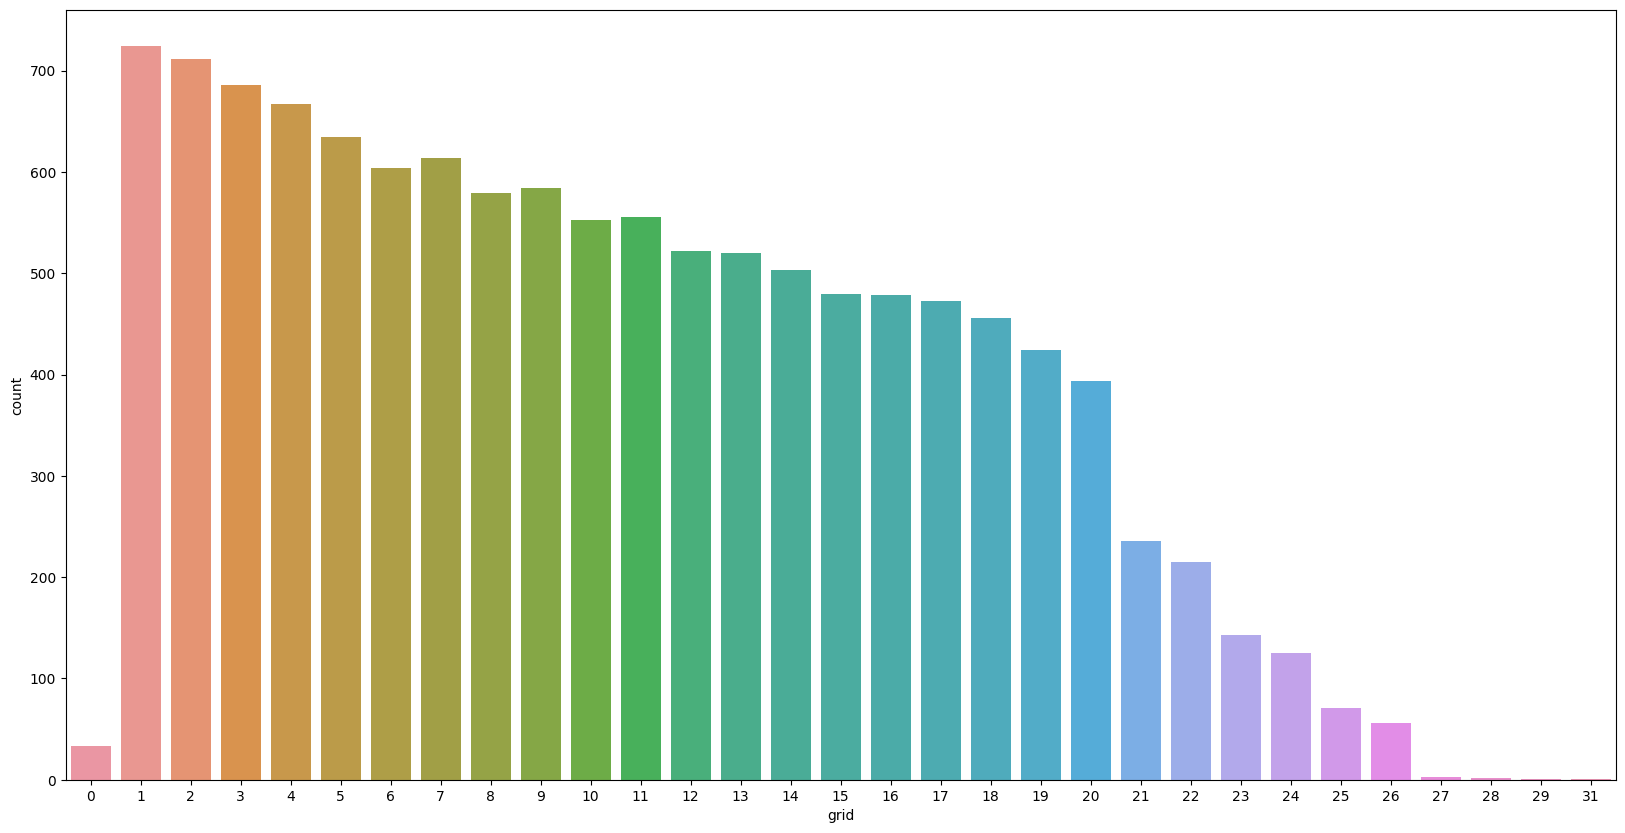

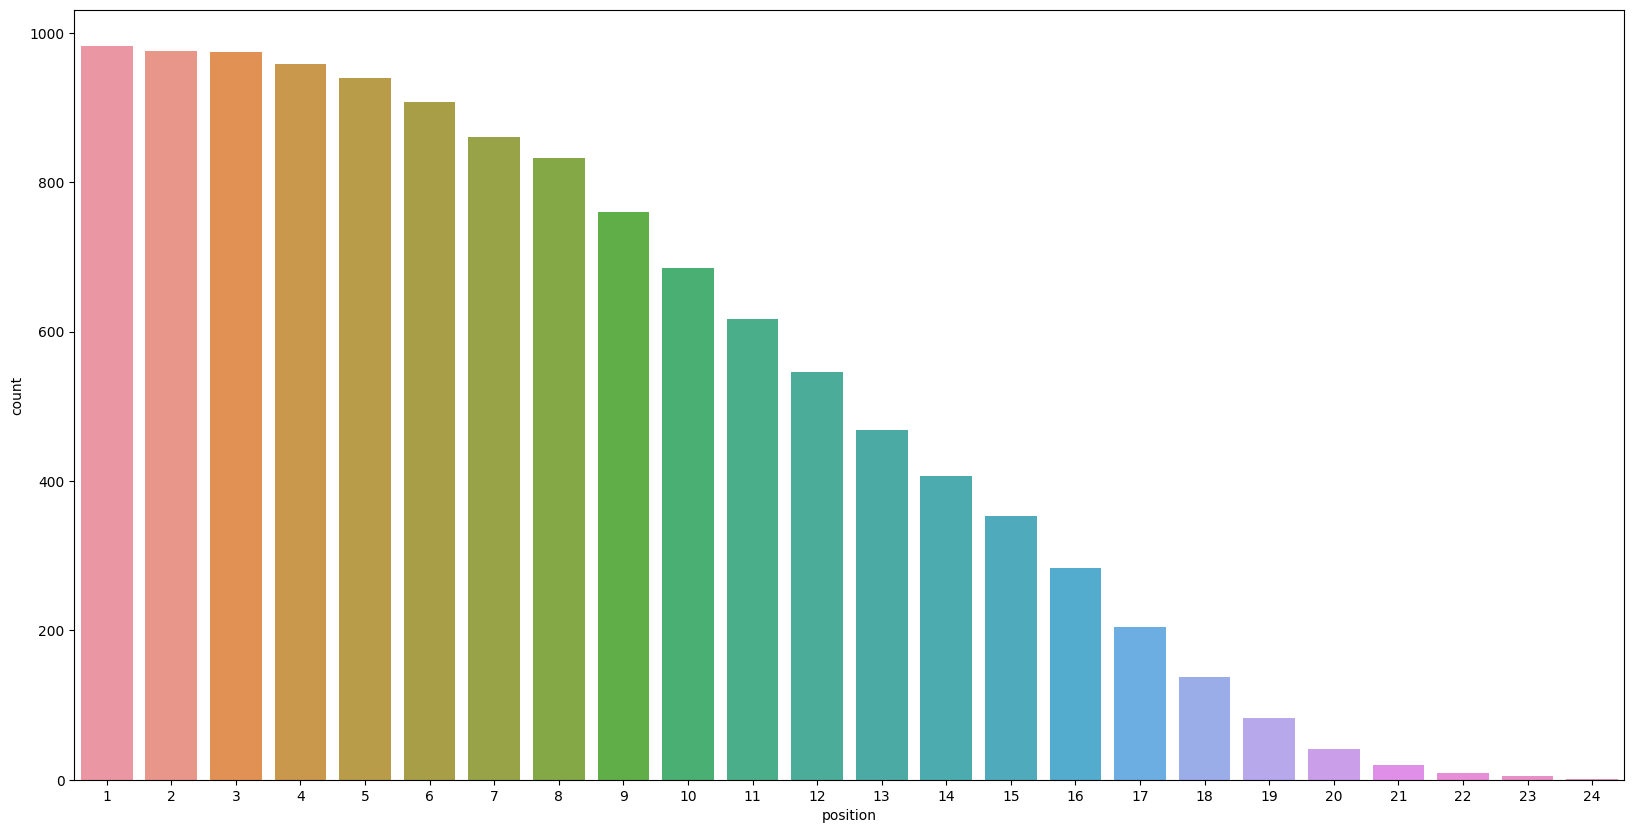

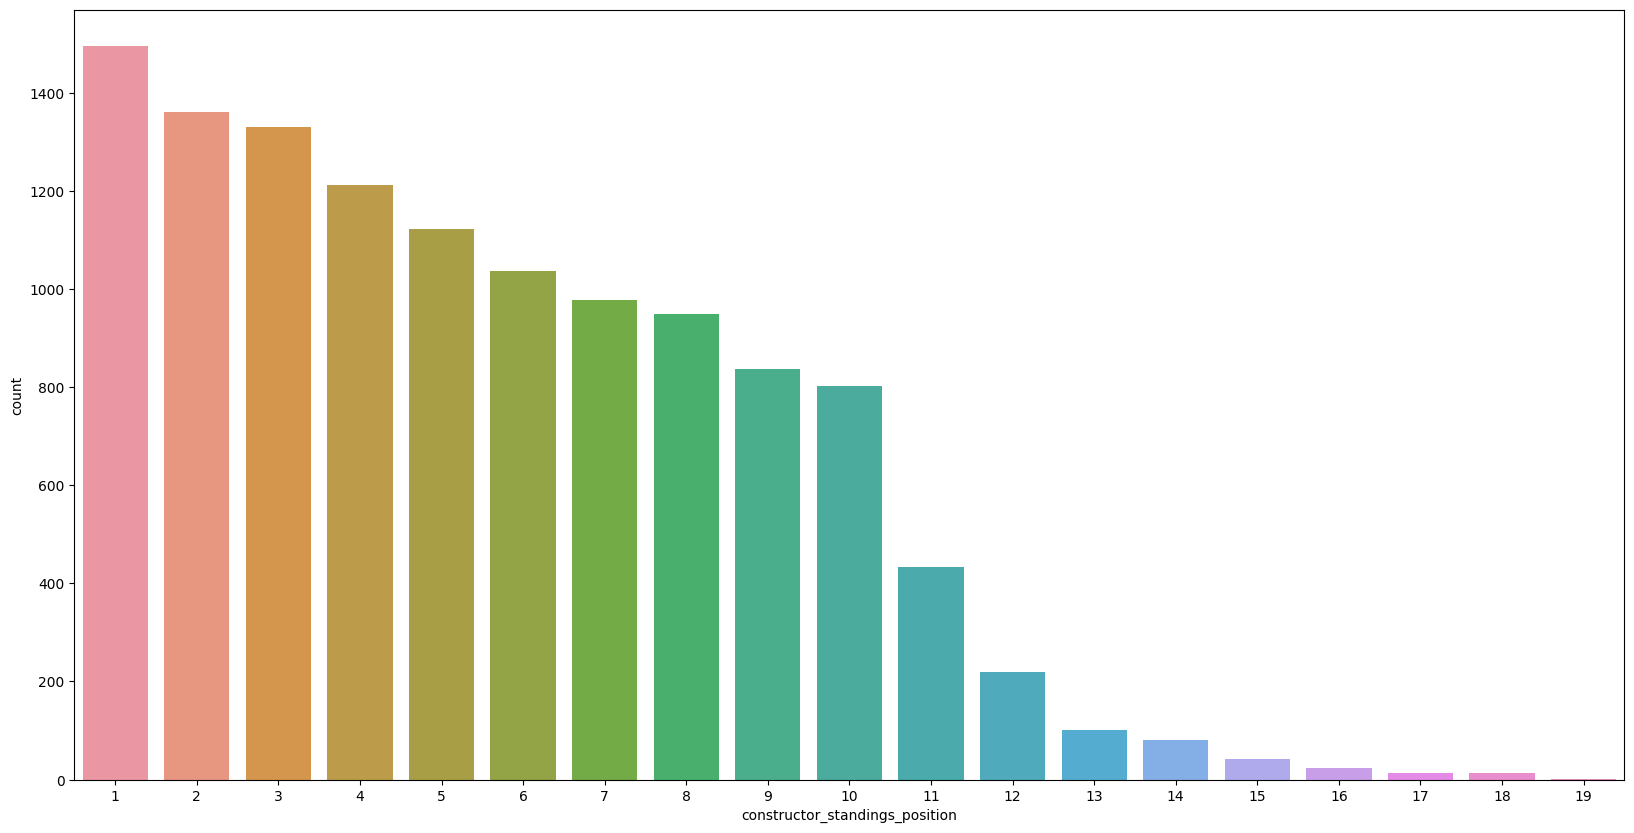

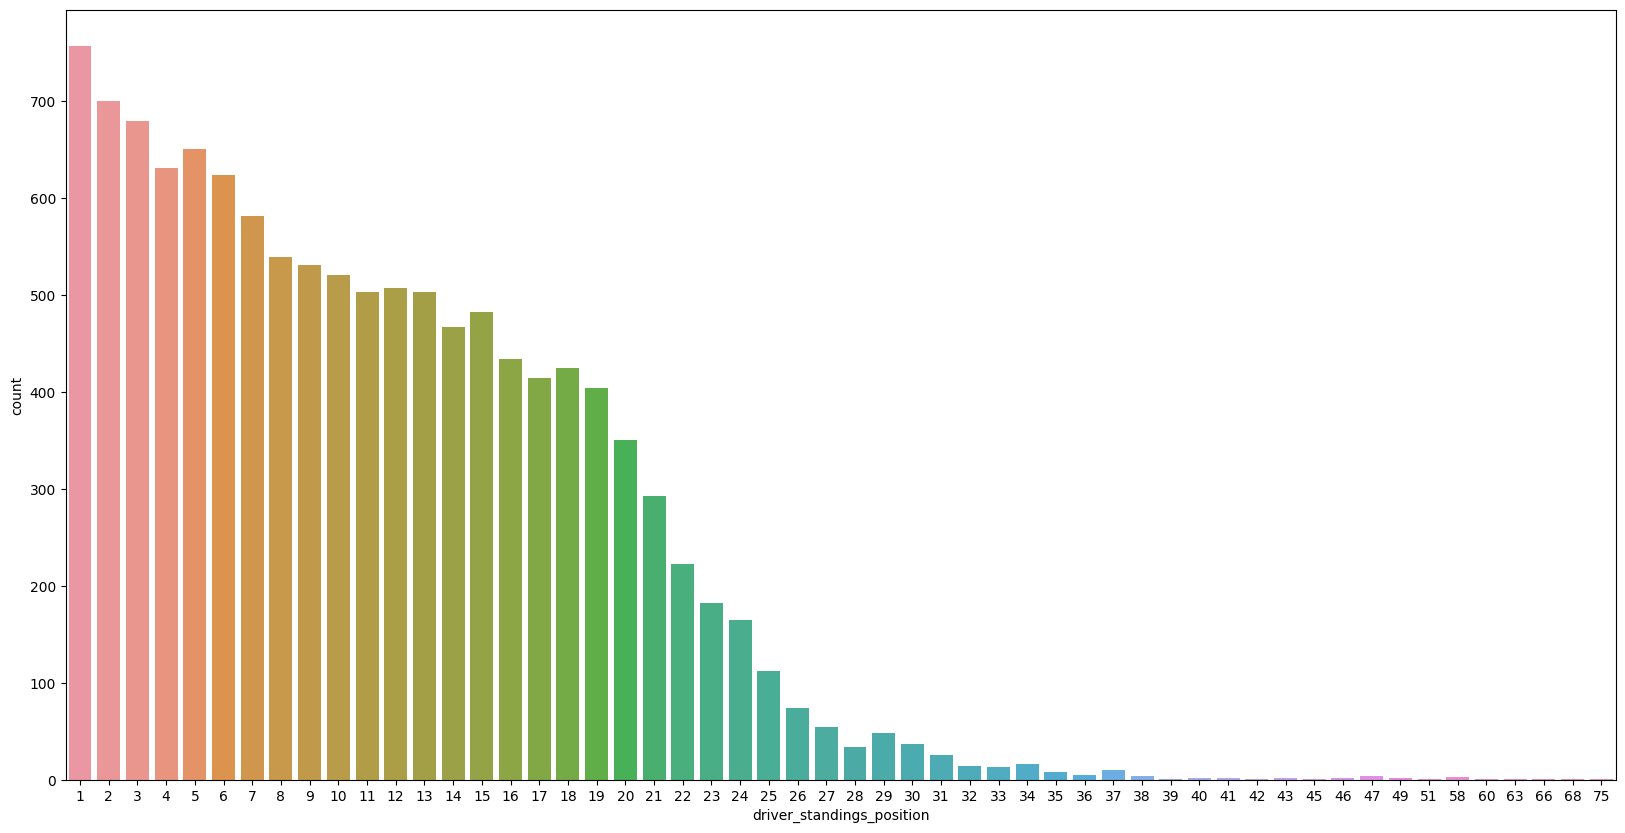

In [13]:
# make bar chart for each column
import matplotlib.pyplot as plt
import seaborn as sns

# grid
plt.figure(figsize=(20,10))
sns.countplot(x='grid', data=train_df)
plt.show()

# position
plt.figure(figsize=(20,10))
sns.countplot(x='position', data=train_df)
plt.show()

# constructor_standings_position
plt.figure(figsize=(20,10))
sns.countplot(x='constructor_standings_position', data=train_df)
plt.show()

# driver_standings_position
plt.figure(figsize=(20,10))
sns.countplot(x='driver_standings_position', data=train_df)
plt.show()

### my comments on the charts
#### grid
    1. data has zero grid position, which is not possible, so I will drop them
    2. there are drivers who have grid more than 22 , this is not common since 2010 so I will use only data from 2010
    3. other than than the bar chart is almost flat, which is great, it declines as the grid position increases becuuse not always all the cars join the race for technical issues or other reasons( in around 2005, 16 cars out of 20 refused to race in the US grand prix as a protest against the FIA)
#### position
    1. Looks GREAT!!!, the chart is almost flat, which means that the drivers are almost equally distributed in the positions, which is just right
    2. of course there is a slight drop as the position increases, which is normal as not all dirverr complete the race

#### constructor standing
    1. Makes sense, as most of the seasons their are around 10 constructors, so after the 10th position the frequency drops
#### driver standing
    1. Makes sense, as most of the seasons their are around 20 drivers, so after the 20th position the frequency drops

## As the number of driver and constructors is almost constant since 2011 to 2022 so we will take the data from 2011 to 2022

In [14]:
races_df = pd.read_csv('dataset/races.csv')
races_df.head()

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


In [15]:
races_between_2011_2022 = races_df[(races_df['year'] >= 2006) & (races_df['year'] <= 2022)]
# sort by year
sorted_races = races_between_2011_2022.sort_values(by='raceId', ascending=True)
sorted_races.head()

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


In [16]:
# keep joined_df having raceId between 2011 and 2022
joined_df_modern = joined_df[joined_df['raceId'].isin(races_between_2011_2022['raceId'])]

In [17]:
train_df_modern = joined_df_modern[['grid','position','constructor_standings_position','driver_standings_position']]
# drop where gris is zero, zero is someone who is not allowed to attend the race
# as a penalty
train_df_modern = train_df_modern[train_df_modern['grid'] != 0]

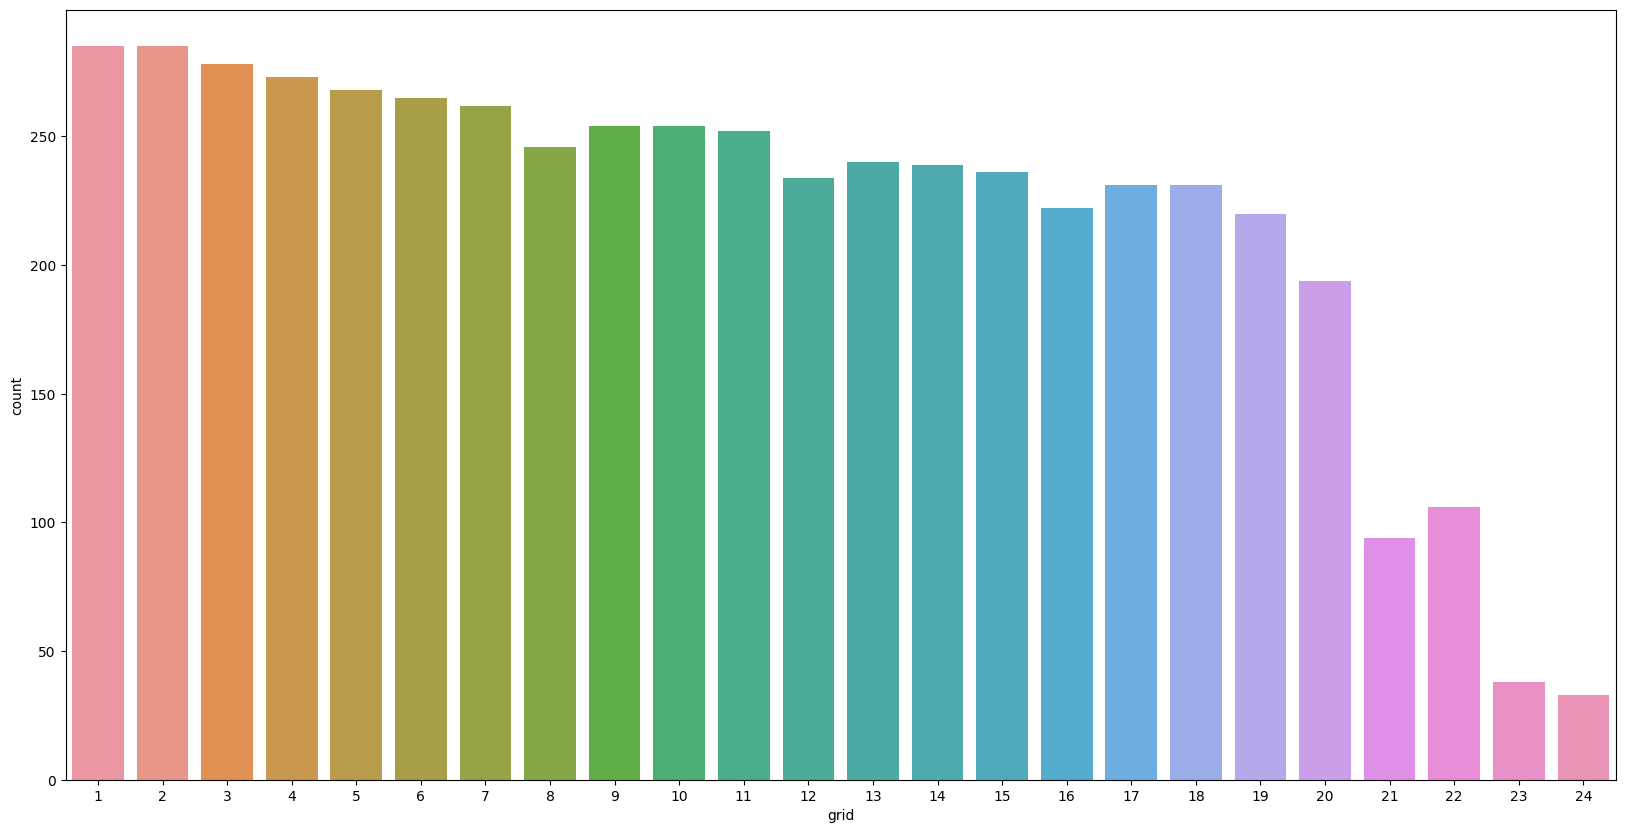

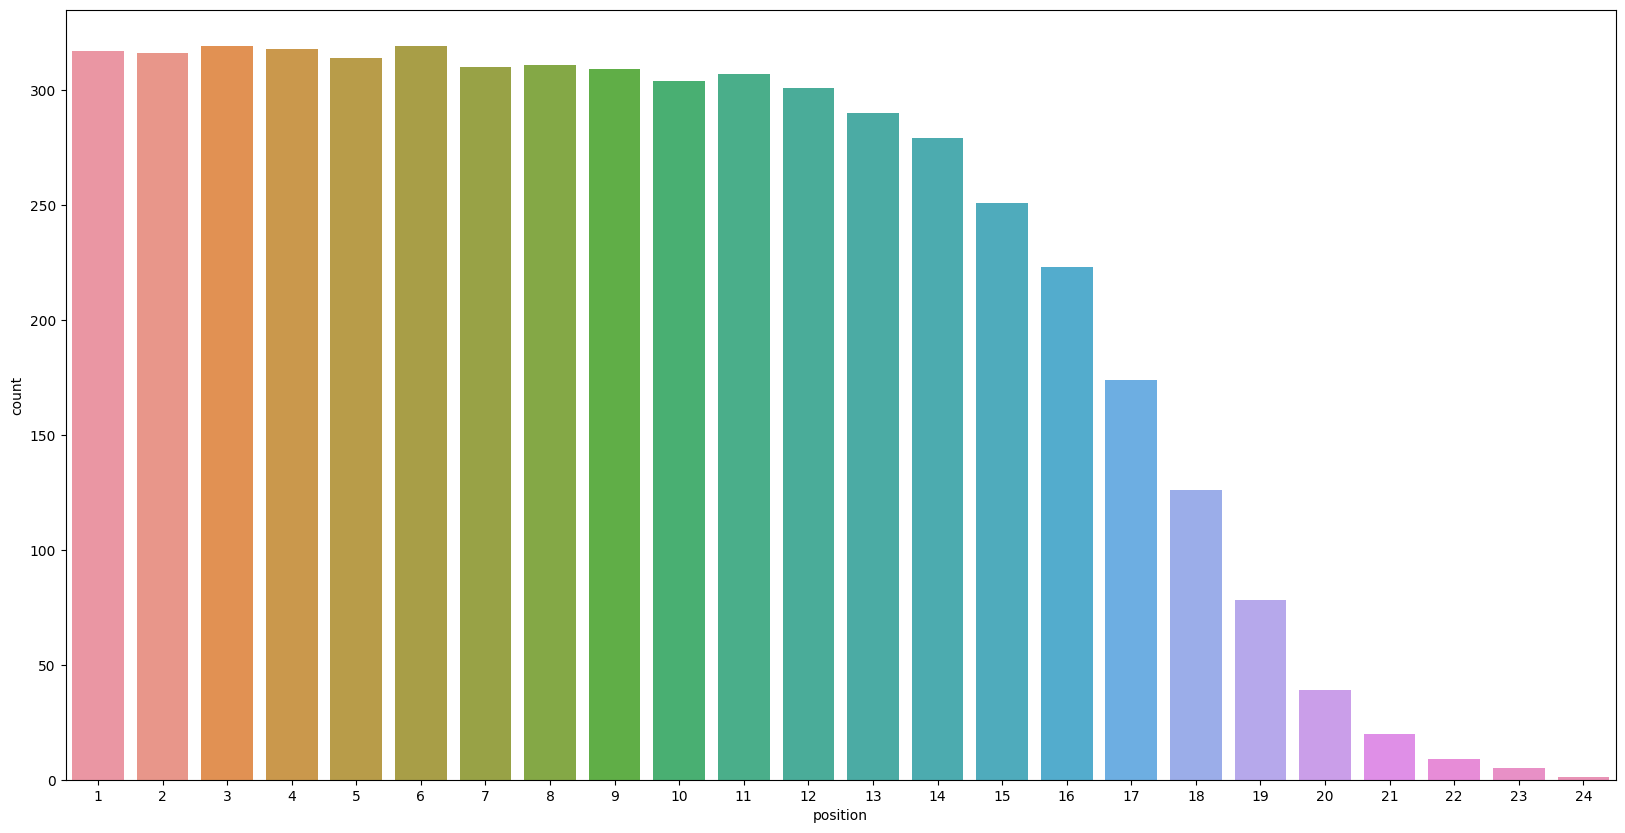

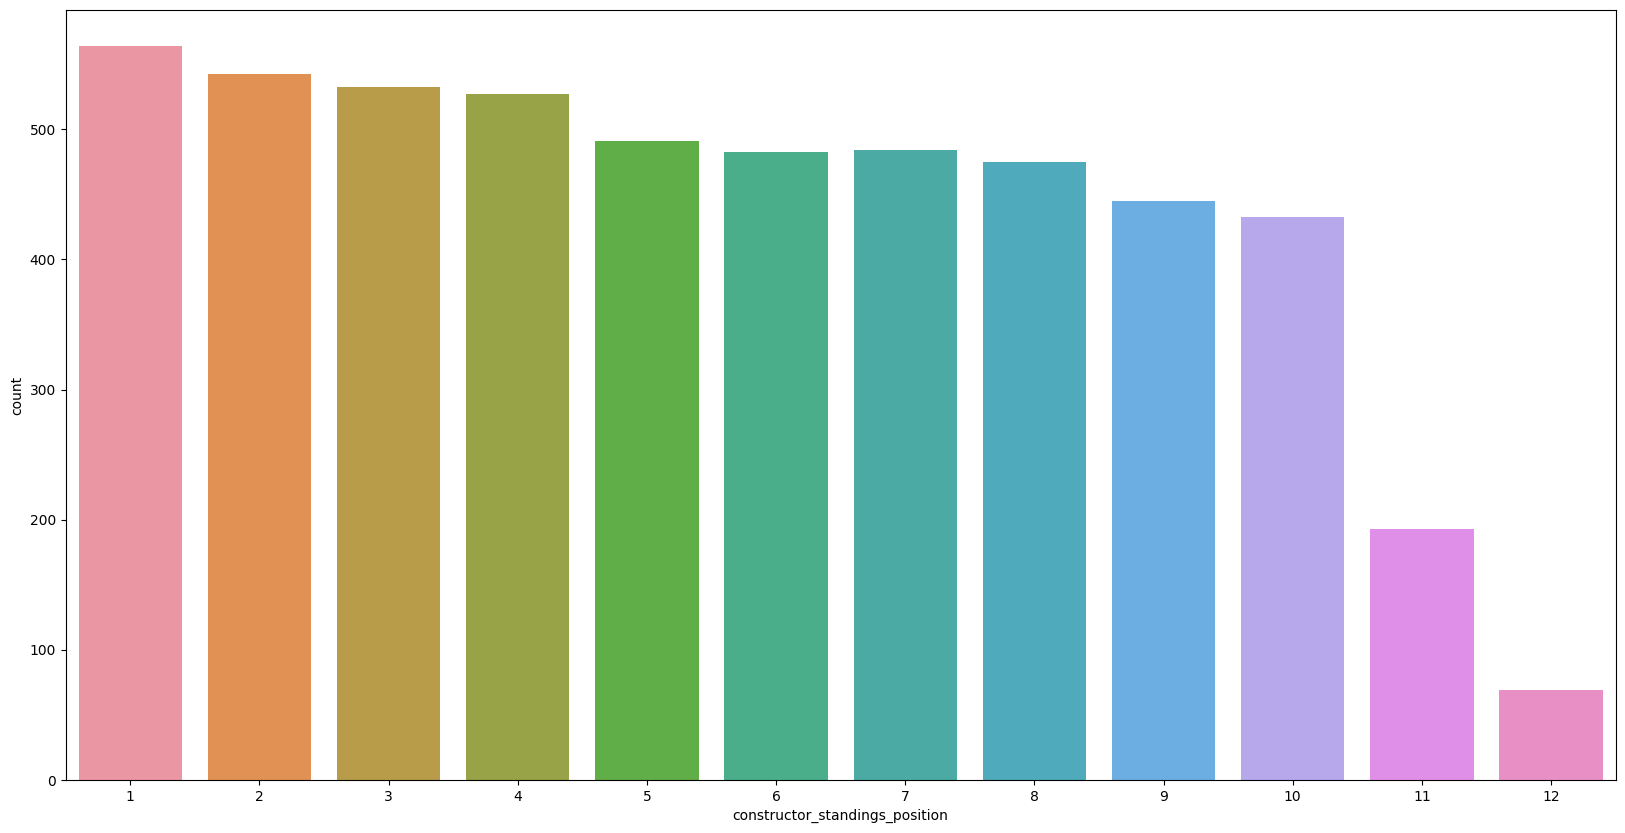

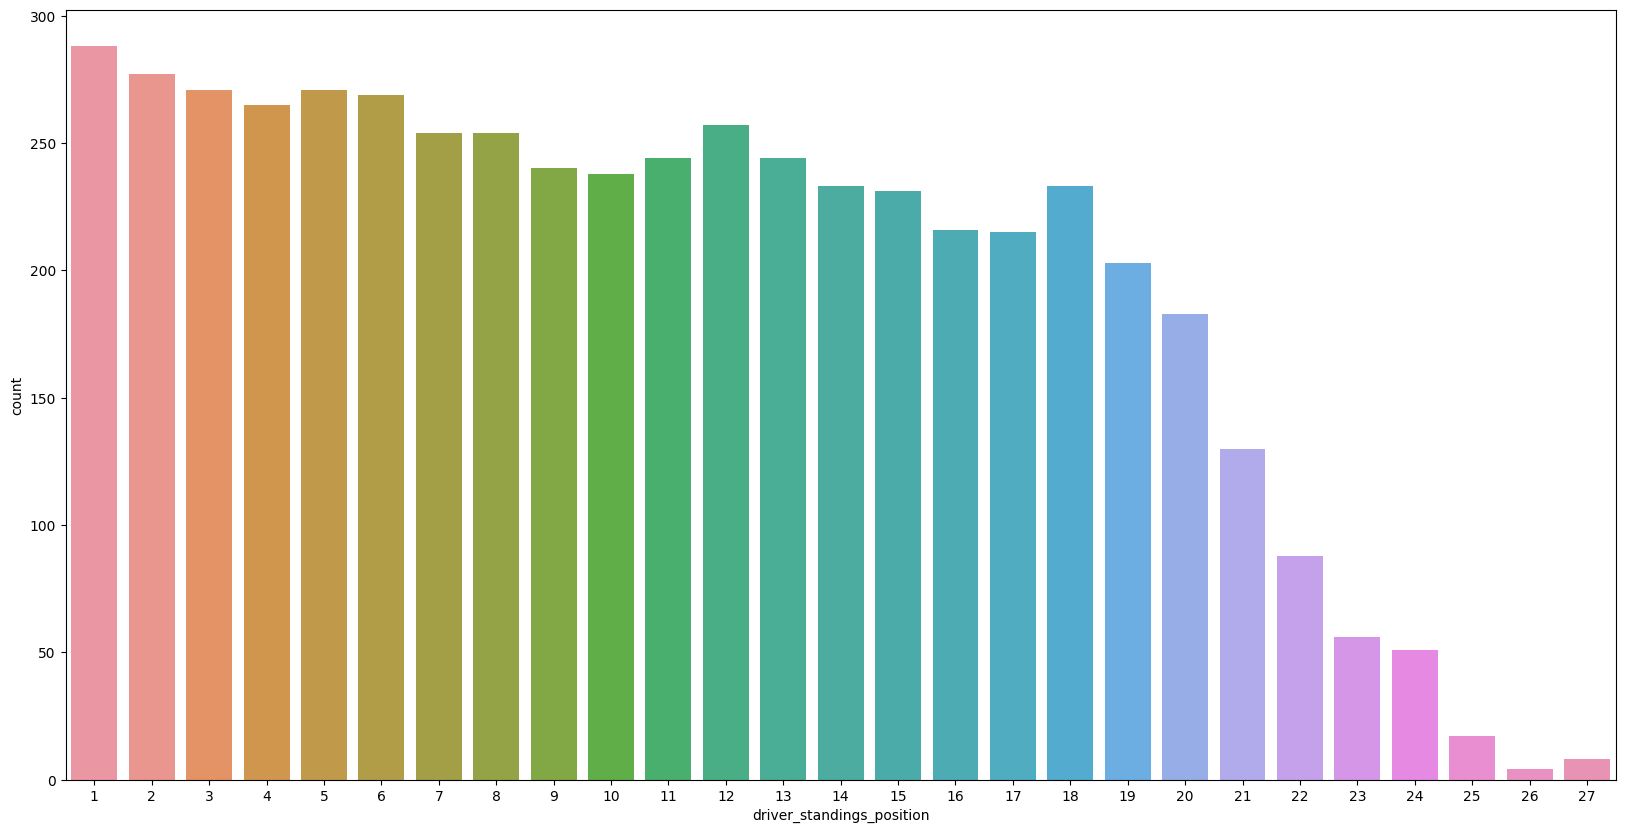

In [18]:
# make bar chart for each column
import matplotlib.pyplot as plt
import seaborn as sns

# grid
plt.figure(figsize=(20,10))
sns.countplot(x='grid', data=train_df_modern)
plt.show()

# position
plt.figure(figsize=(20,10))
sns.countplot(x='position', data=train_df_modern)
plt.show()

# constructor_standings_position
plt.figure(figsize=(20,10))
sns.countplot(x='constructor_standings_position', data=train_df_modern)
plt.show()

# driver_standings_position
plt.figure(figsize=(20,10))
sns.countplot(x='driver_standings_position', data=train_df_modern)
plt.show()

### my comments on the charts
#### grid
    1. Removed Zero grid position as it turned out that zero is someone who started from the pit lane or cant attend the race as penalty
    2. now the bar chart is almost flat and way better than before
#### position
    1. even flatter than before, and decreases darastically after the 20th position, as omst of the races has only 20 drivers
#### constructor standing
    1. Makes sense, as most of the seasons their are around 10 constructors, so after the 10th position the frequency drops
#### driver standing
    1. Makes sense, as most of the seasons their are around 20 drivers, so after the 20th position the frequency drops

#### in general the charts changed a little bit to being more constant

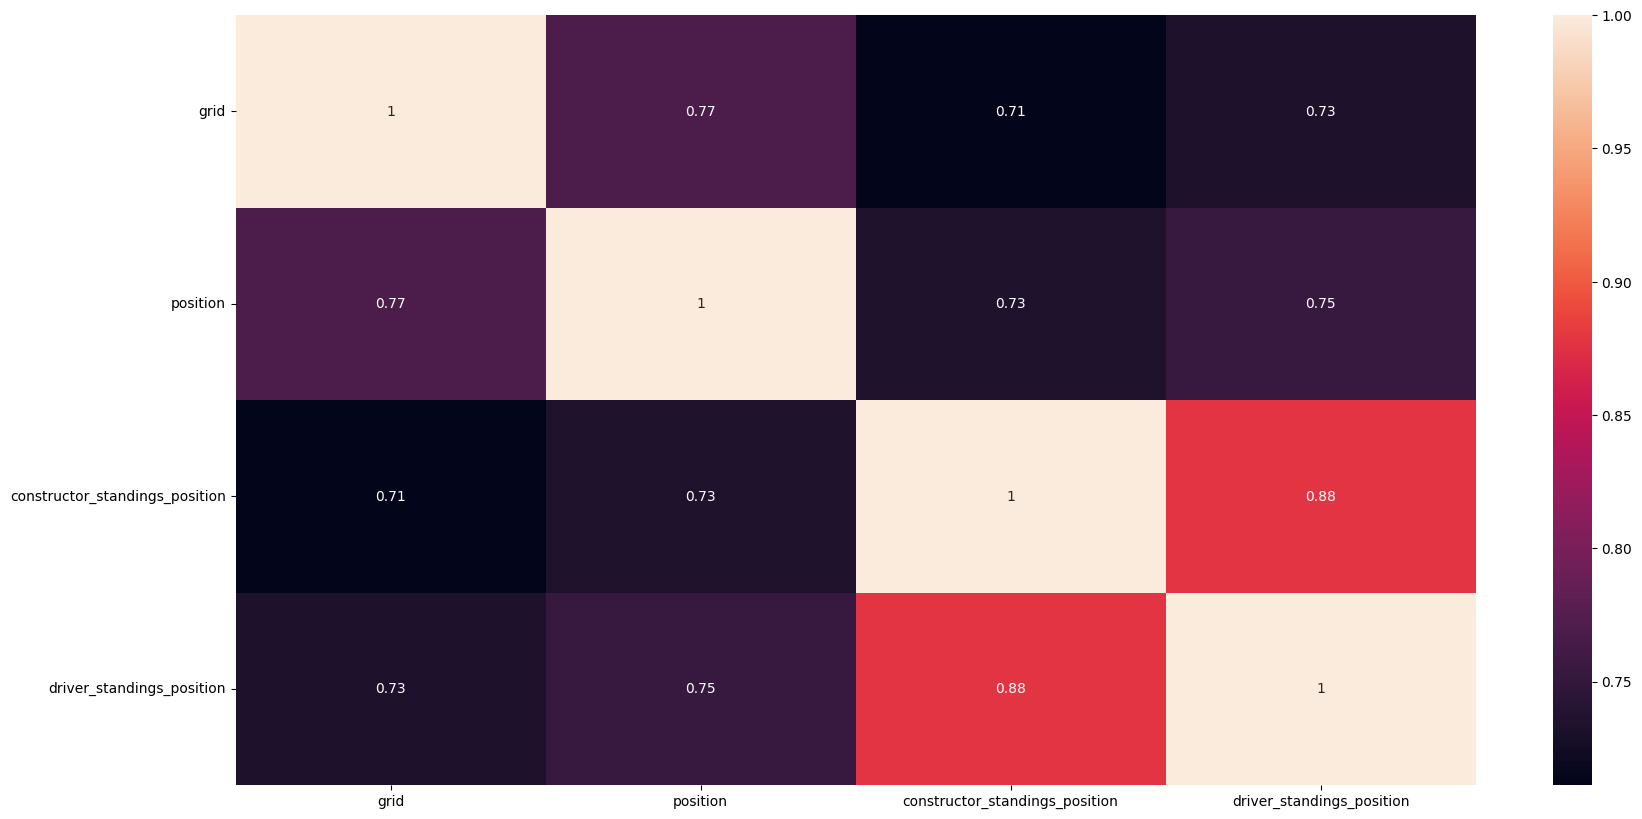

In [19]:
# draw the correlation matrix
plt.figure(figsize=(20,10))
sns.heatmap(train_df_modern.corr(), annot=True)
plt.show()


## The correlation matrix clearly shows that the columns we chose to predict the position are highly correlated with the position, which is great

In [20]:
X = train_df_modern[['grid','constructor_standings_position','driver_standings_position']]
y = train_df_modern['position']

In [21]:
len(X), len(y)

(5240, 5240)

In [22]:
# split the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=0.2)

In [23]:
# train the model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [24]:
# get accuracy and r2 score
from sklearn.metrics import accuracy_score, r2_score
y_pred = model.predict(X_test)
print('accuracy score: ', accuracy_score(y_test, y_pred.round()))
print('r2 score: ', r2_score(y_test, y_pred))


accuracy score:  0.14599236641221375
r2 score:  0.674174723411324


In [25]:
# classification using a neural network
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, alpha=0.0001, solver='sgd', verbose=10, random_state=42, tol=0.000000001)
model.fit(X_train, y_train)


Iteration 1, loss = 3.30409804
Iteration 2, loss = 3.06706450
Iteration 3, loss = 3.01003511
Iteration 4, loss = 2.97901759
Iteration 5, loss = 2.95600455
Iteration 6, loss = 2.93519420
Iteration 7, loss = 2.91683707
Iteration 8, loss = 2.90033489
Iteration 9, loss = 2.88547628
Iteration 10, loss = 2.87049341
Iteration 11, loss = 2.85590388
Iteration 12, loss = 2.84240786
Iteration 13, loss = 2.82853986
Iteration 14, loss = 2.81532980
Iteration 15, loss = 2.80299090
Iteration 16, loss = 2.78827630
Iteration 17, loss = 2.77539193
Iteration 18, loss = 2.76213932
Iteration 19, loss = 2.75060815
Iteration 20, loss = 2.73639615
Iteration 21, loss = 2.72279451
Iteration 22, loss = 2.71127086
Iteration 23, loss = 2.69777556
Iteration 24, loss = 2.68447951
Iteration 25, loss = 2.67232929
Iteration 26, loss = 2.66036998
Iteration 27, loss = 2.64897467
Iteration 28, loss = 2.63644515
Iteration 29, loss = 2.62422496
Iteration 30, loss = 2.61410865
Iteration 31, loss = 2.60245925
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=500, random_state=42,
              solver='sgd', tol=1e-09, verbose=10)

In [26]:
# get accuracy and F1 score
from sklearn.metrics import accuracy_score, f1_score
y_pred = model.predict(X_test)
print('accuracy score: ', accuracy_score(y_test, y_pred))
print('f1 score: ', f1_score(y_test, y_pred, average='weighted'))

accuracy score:  0.19083969465648856
f1 score:  0.16910463889257515


The accuracy is not that bad, random guess would give us 5% accuracy, so 20% is not that bad


Especially That Fomrula one is a higly complex sport and a lot of other factors may affect the race results like wind speed, weather, track altitude and even lots of different accidentds or random things that happen every single race

### What to do to try to improve the 

1. Make a larger dataset getting races from 2000 to 2022
2. Reduce the number of ranks in constrctor < so the maximum number of constructor ranking is 10 to have a more consistent dataset and more accurate results
3. Reduce the number of ranks in driver < so the maximum number of driver ranking is 20 to have a more consistent dataset and more accurate results
4. Use a more complex model like SVM

In [27]:
races_wanted = races_df[(races_df['year'] >= 1970) & (races_df['year'] <= 2022)]


In [28]:
new_joined_df = joined_df[joined_df['raceId'].isin(races_wanted['raceId'])]


In [29]:
new_train = new_joined_df[['grid','position','constructor_standings_position','driver_standings_position']]
new_train = new_train[new_train['grid'] != 0]
# drop where grid is more than 20
new_train = new_train[new_train['grid'] <= 20]
# drop where position is more than 20
new_train = new_train[new_train['position'] <= 20]
# drop where cosntuctor_standings_position is more than 10
new_train = new_train[new_train['constructor_standings_position'] <= 10]
# drop where driver_standings_position is more than 20
new_train = new_train[new_train['driver_standings_position'] <= 20]

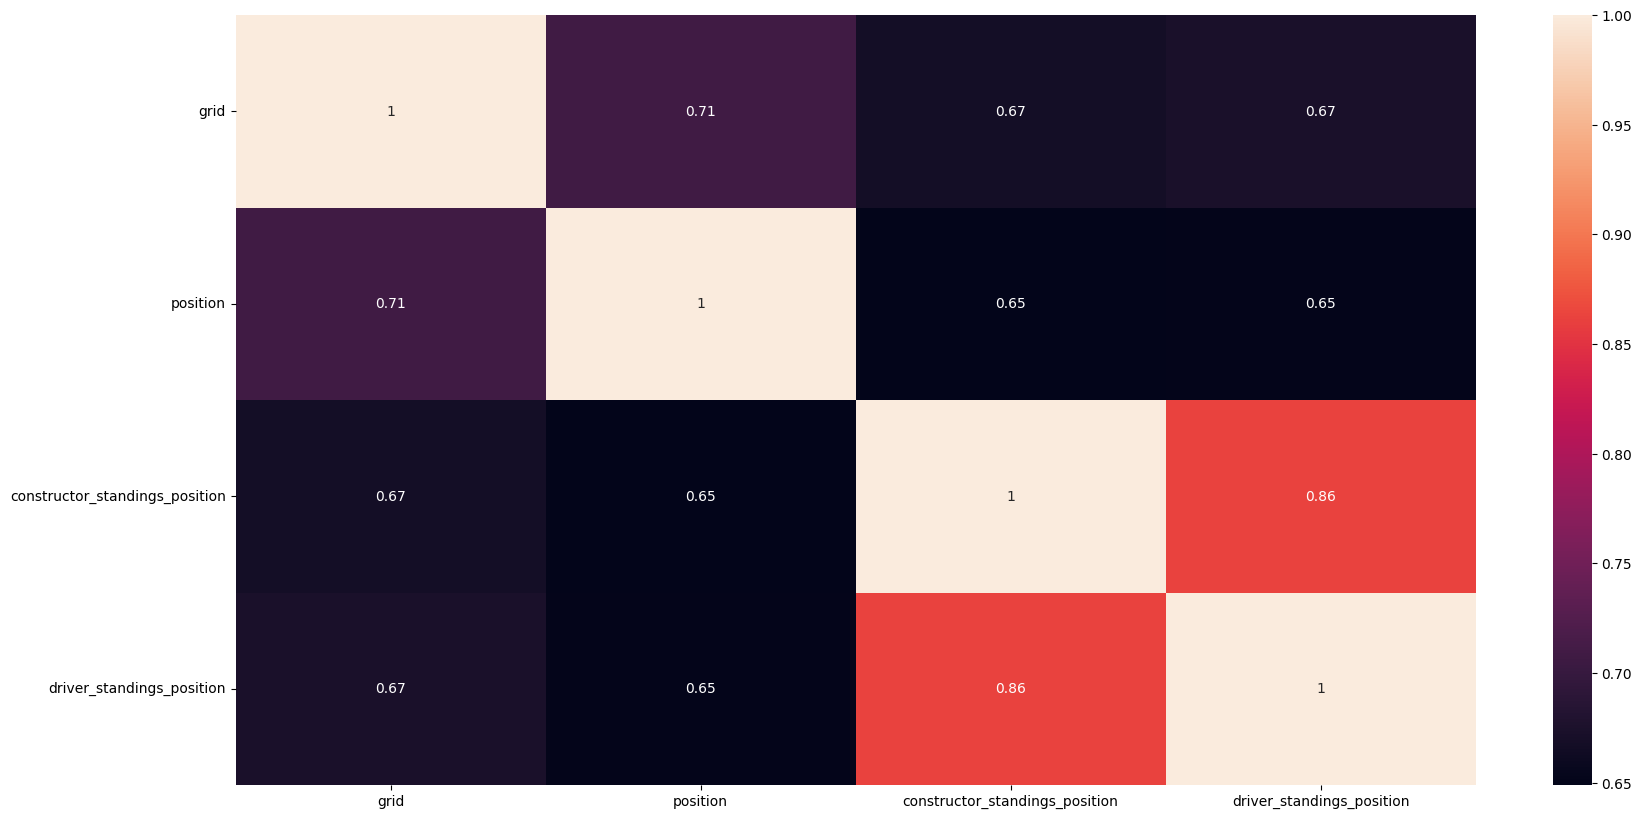

In [30]:

# draw the correlation matrix
# but his time using spearman correlation
# as it is more suitable for discrete data
plt.figure(figsize=(20,10))
sns.heatmap(new_train.corr('spearman'), annot=True)
plt.show()


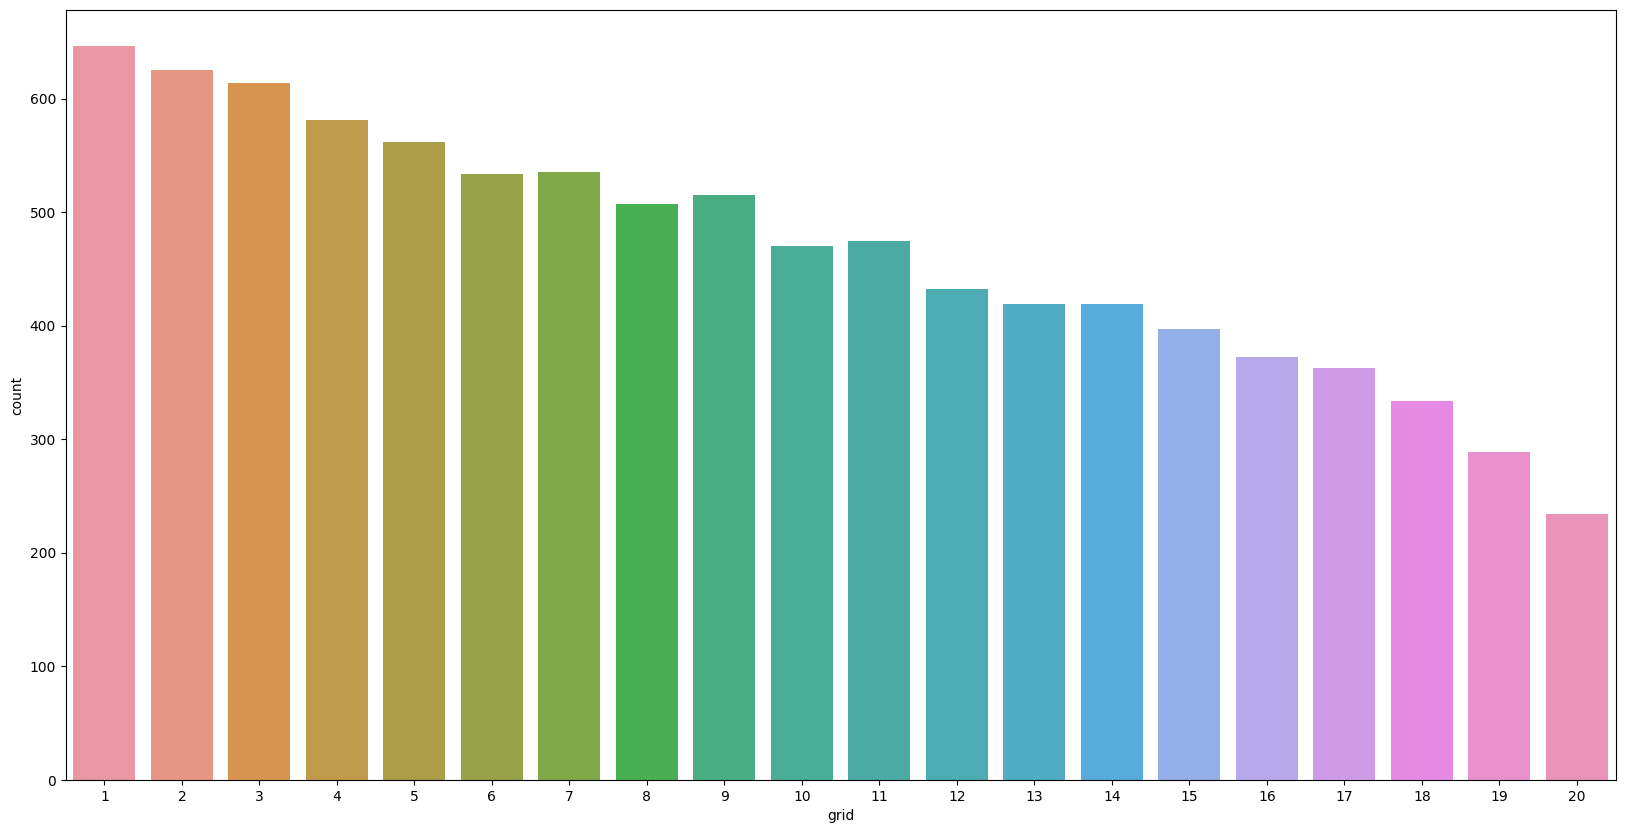

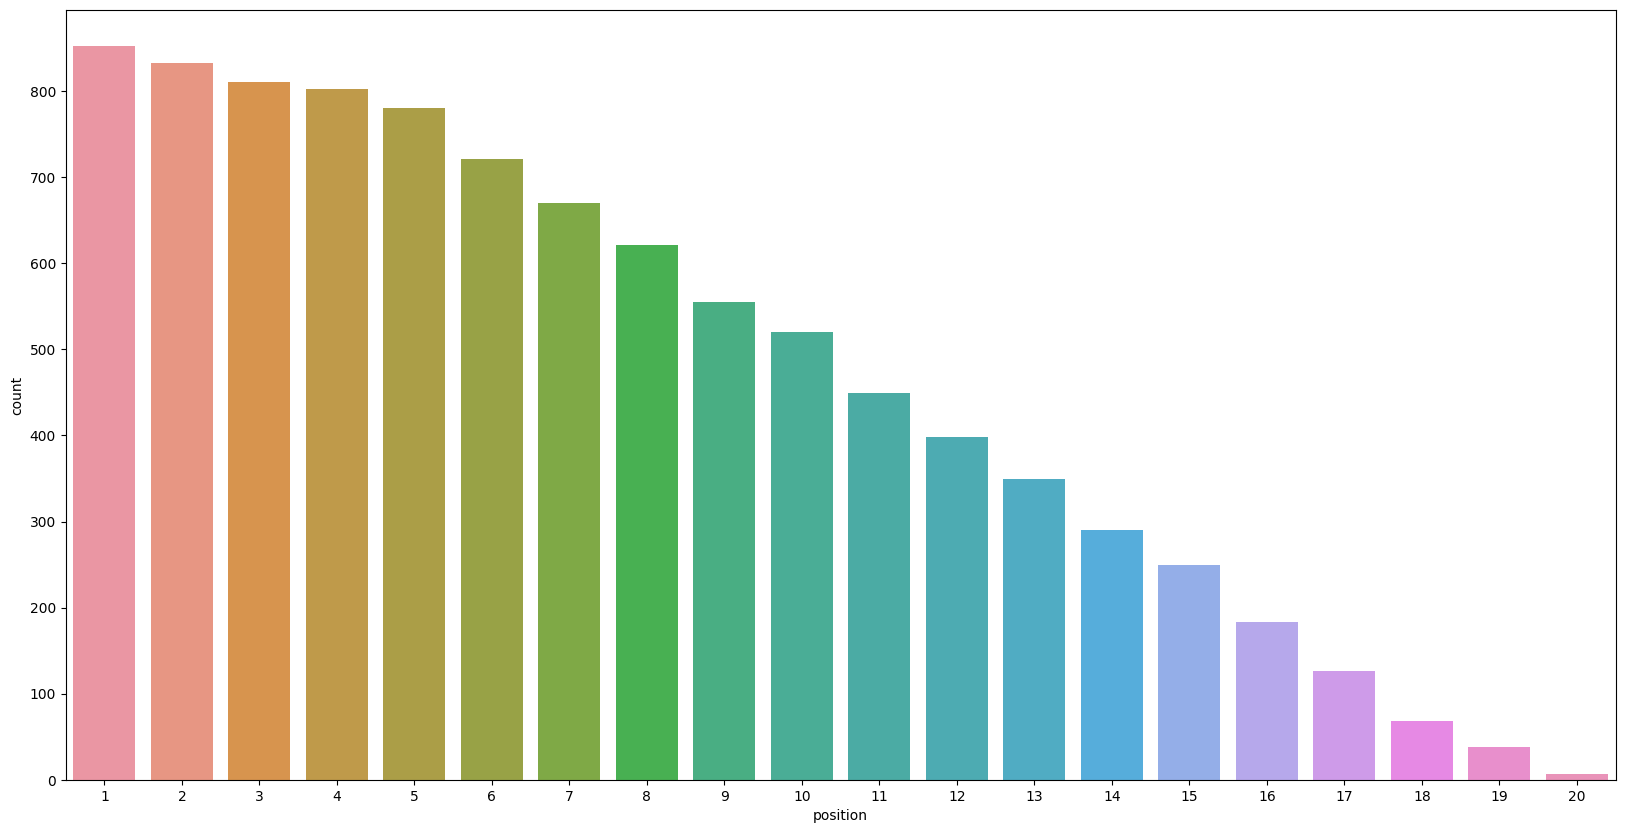

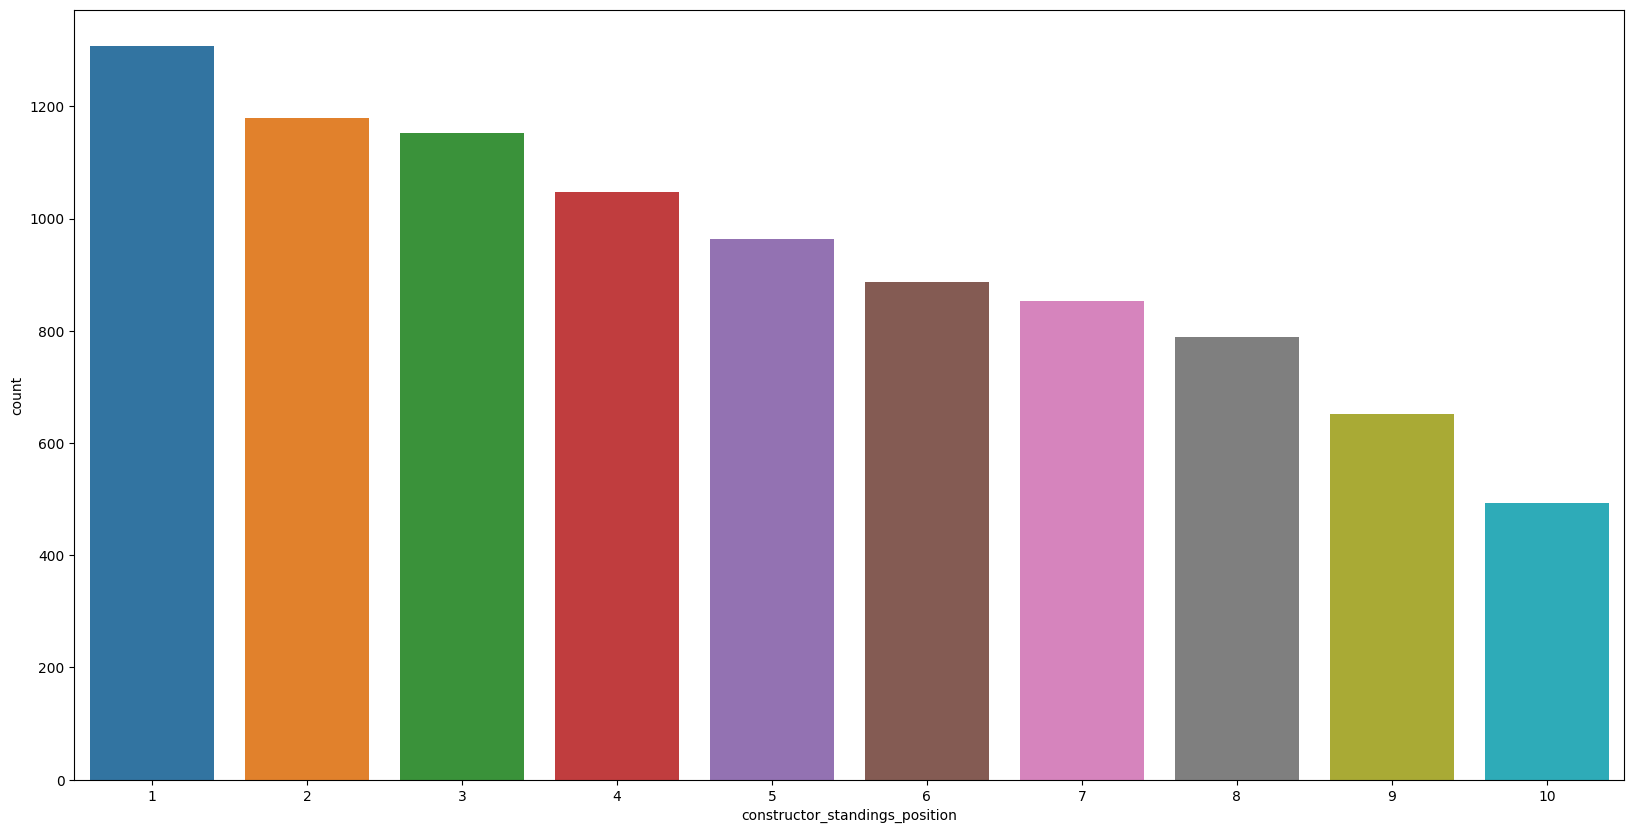

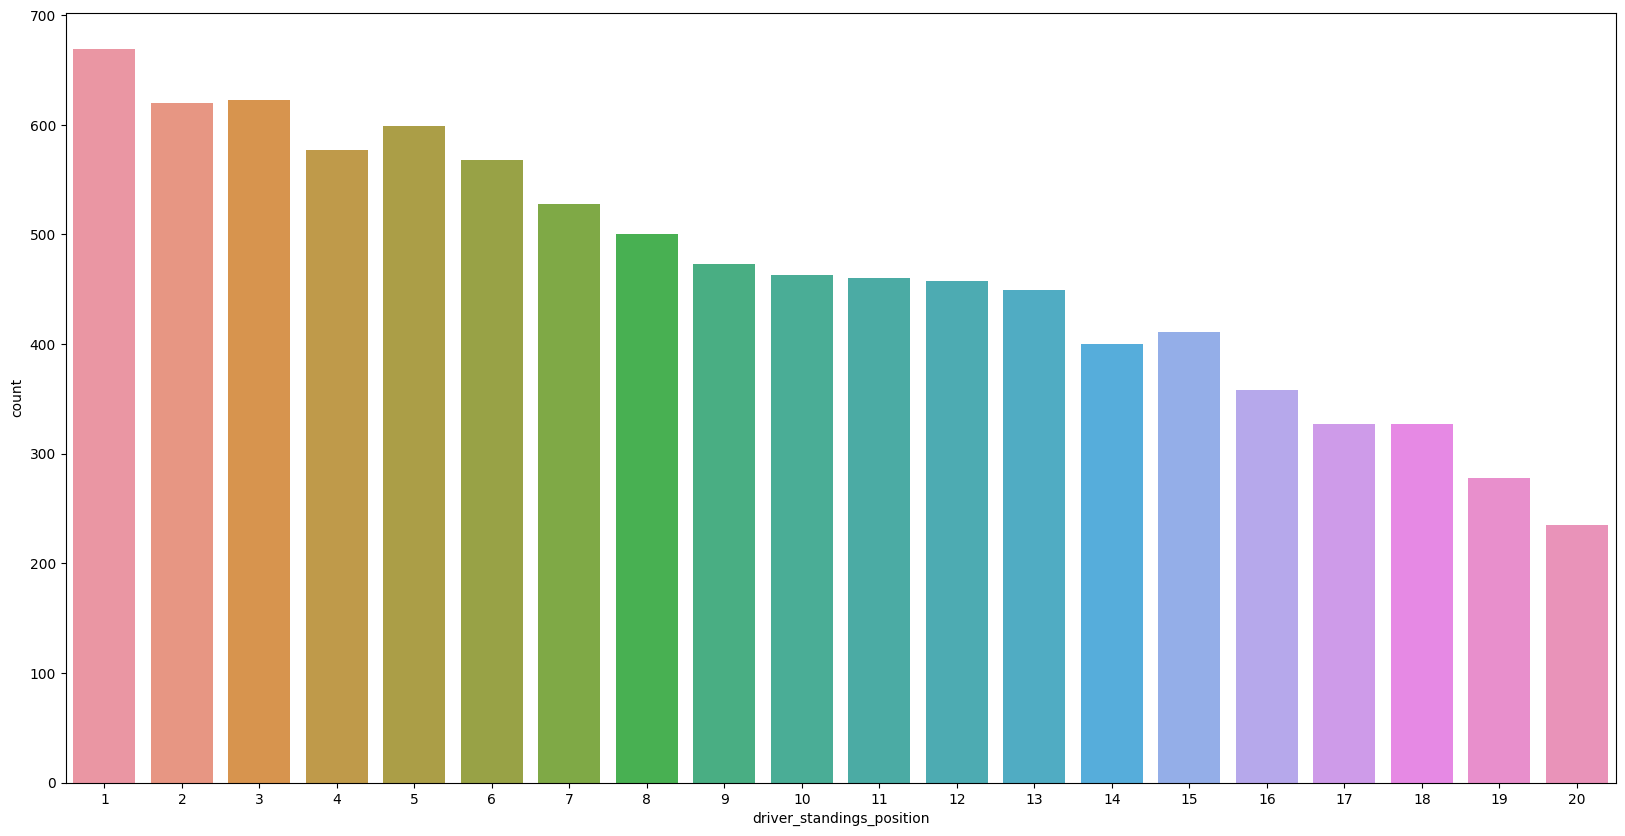

In [31]:
# make bar chart for each column
import matplotlib.pyplot as plt
import seaborn as sns

# grid
plt.figure(figsize=(20,10))
sns.countplot(x='grid', data=new_train)
plt.show()

# position
plt.figure(figsize=(20,10))
sns.countplot(x='position', data=new_train)
plt.show()

# constructor_standings_position
plt.figure(figsize=(20,10))
sns.countplot(x='constructor_standings_position', data=new_train)
plt.show()

# driver_standings_position
plt.figure(figsize=(20,10))
sns.countplot(x='driver_standings_position', data=new_train)
plt.show()

In [32]:
new_train.to_csv("predict_position.csv")
X = new_train[['grid','constructor_standings_position','driver_standings_position']]
y = new_train['position']
#decrement the position by 1
y = y - 1



In [33]:
# unique values of position
print(y.unique())
print(len(y))

[ 0  4  1  2  5  3  7 13 12  6 17  9 10 11 14  8 16 15 18 19]
9323


In [34]:

# split the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=0.2)

In [47]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
# Create an SVM classifier with an RBF kernel
clf = SVC(kernel='rbf', C=1, gamma='scale')

# Train the SVM classifier on the training set
clf.fit(X_train, y_train)

# Predict the class labels for the testing set
y_pred = clf.predict(X_test)

# Calculate the accuracy score of the SVM classifier
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
# get F1 score
from sklearn.metrics import f1_score
print('f1 score: ', f1_score(y_test, y_pred, average='weighted'))



Accuracy: 0.1880586342509832
f1 score:  0.1625853042190892
Accuracy: 0.14229531641043977
f1 score:  0.0912402833424422


In [36]:
# do KNN
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=20)
model.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=20)

In [37]:
# accuracy
from sklearn.metrics import accuracy_score, f1_score
y_pred = model.predict(X_test)
print('accuracy score: ', accuracy_score(y_test, y_pred))

accuracy score:  0.16246648793565685


In [38]:
# fully connected nueral netwrok 
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, alpha=0.0001, solver='sgd', verbose=10, random_state=42, tol=0.000000001)
model.fit(X_train, y_train)

# get accuracy and F1 score
from sklearn.metrics import accuracy_score, f1_score
y_pred = model.predict(X_test)
print('accuracy score: ', accuracy_score(y_test, y_pred))
print('f1 score: ', f1_score(y_test, y_pred, average='weighted'))


Iteration 1, loss = 2.99520812
Iteration 2, loss = 2.85298382
Iteration 3, loss = 2.81485519
Iteration 4, loss = 2.78629746
Iteration 5, loss = 2.76200104
Iteration 6, loss = 2.73885571
Iteration 7, loss = 2.71739855
Iteration 8, loss = 2.69451023
Iteration 9, loss = 2.67258550
Iteration 10, loss = 2.65218693
Iteration 11, loss = 2.62977518
Iteration 12, loss = 2.60920355
Iteration 13, loss = 2.58745371
Iteration 14, loss = 2.56749079
Iteration 15, loss = 2.54751131
Iteration 16, loss = 2.52867714
Iteration 17, loss = 2.51061546
Iteration 18, loss = 2.49382437
Iteration 19, loss = 2.47825886
Iteration 20, loss = 2.46521271
Iteration 21, loss = 2.45185070
Iteration 22, loss = 2.43989590
Iteration 23, loss = 2.42969924
Iteration 24, loss = 2.42150229
Iteration 25, loss = 2.41449611
Iteration 26, loss = 2.40928476
Iteration 27, loss = 2.40209367
Iteration 28, loss = 2.39699737
Iteration 29, loss = 2.39325976
Iteration 30, loss = 2.38911100
Iteration 31, loss = 2.38605632
Iteration 32, los

In [44]:

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from copy import deepcopy

# X = new_train[['grid','constructor_standings_position','driver_standings_position']]
# y = new_train['position']
# Load the data
data = deepcopy(new_train)


# Convert the data to one-hot encoded vectors
enc = OneHotEncoder(sparse=False)
X = enc.fit_transform(data.drop('position', axis=1))
y = data['position'].values - 1  # Subtract 1 to convert position to 0-based index

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train_X, train_y = X[:train_size], y[:train_size]
test_X, test_y = X[train_size:], y[train_size:]

# Define the deep learning model
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Set hyperparameters
input_size = X.shape[1]
hidden_size = 64
output_size = len(np.unique(y))
learning_rate = 0.001
num_epochs = 1000
batch_size = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create model and optimizer
model = Model(input_size, hidden_size, output_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Train the model
for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    num_batches = 0
    for i in range(0, len(train_X), batch_size):
        batch_X = torch.tensor(train_X[i:i+batch_size]).float().to(device)
        batch_y = torch.tensor(train_y[i:i+batch_size]).long().to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_X.size(0)
        train_acc += torch.sum(torch.max(outputs, 1)[1] == batch_y)
        num_batches += 1
    train_loss /= len(train_X)
    train_acc /= len(train_X)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')


Epoch [1/1000], Train Loss: 2.9139, Train Acc: 0.0893
Epoch [2/1000], Train Loss: 2.6654, Train Acc: 0.1230
Epoch [3/1000], Train Loss: 2.5349, Train Acc: 0.1498
Epoch [4/1000], Train Loss: 2.4752, Train Acc: 0.1667
Epoch [5/1000], Train Loss: 2.4461, Train Acc: 0.1689
Epoch [6/1000], Train Loss: 2.4398, Train Acc: 0.1692
Epoch [7/1000], Train Loss: 2.4203, Train Acc: 0.1759
Epoch [8/1000], Train Loss: 2.4108, Train Acc: 0.1786
Epoch [9/1000], Train Loss: 2.4090, Train Acc: 0.1755
Epoch [10/1000], Train Loss: 2.3991, Train Acc: 0.1807
Epoch [11/1000], Train Loss: 2.3944, Train Acc: 0.1799
Epoch [12/1000], Train Loss: 2.3950, Train Acc: 0.1836
Epoch [13/1000], Train Loss: 2.3918, Train Acc: 0.1773
Epoch [14/1000], Train Loss: 2.3873, Train Acc: 0.1769
Epoch [15/1000], Train Loss: 2.3808, Train Acc: 0.1838
Epoch [16/1000], Train Loss: 2.3809, Train Acc: 0.1865
Epoch [17/1000], Train Loss: 2.3739, Train Acc: 0.1799
Epoch [18/1000], Train Loss: 2.3761, Train Acc: 0.1853
Epoch [19/1000], Tr

In [46]:

# Test the model
test_loss = 0.0
test_acc = 0.0
num_batches = 0
with torch.no_grad():
    for i in range(0, len(test_X), batch_size):
        batch_X = torch.tensor(test_X[i:i+batch_size]).float().to(device)
        batch_y = torch.tensor(test_y[i:i+batch_size]).long().to(device)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item() * batch_X.size(0)
        test_acc += torch.sum(torch.max(outputs, 1)[1] == batch_y)
        num_batches += 1
test_loss /= len(test_X)
test_acc /= len(test_X)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')


# calculate f1 score without using sklearn
with torch.no_grad():
    y_pred_tensor = model(torch.tensor(test_X).float().to(device))
    _, y_pred_classes_tensor = torch.max(y_pred_tensor, dim=1)
    y_pred_classes = y_pred_classes_tensor.cpu().numpy()
        
    # Calculate the accuracy score of the model
    accuracy = accuracy_score(test_y, y_pred_classes)
    
    # Print the loss and accuracy at the end of each epoch
    print(f'Accuracy: {accuracy:.4f}')
    print('f1 score: ', f1_score(test_y, y_pred_classes, average='weighted'))
    

Test Loss: 2.7753, Test Acc: 0.1485
Accuracy: 0.1496
f1 score:  0.12878611082743244


## As a conclusion
1. The best model is the normal fully connected neural network
2. The best accuracy is around 20%
3. More features would make the model more accurate
4. But in total, F1 is a really complex sport and it is really hard to predict the results, having 20% accuracy is not that bad, in general it will be hard to even have a model that approaches 50% accuracy, except if we have a really large dataset with a lot of features like the aerodynamics of each vehicle and the race weather coniditions, the reflexes of the driver and more